In [1311]:

import os
import inspect
import sys
sys.path.insert(0, "../")


from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt



import pandas as pd
import numpy as np
import logging
import pprint
import re
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 1
# mpl.rcParams['legend.fontsize'] = 13

# mpl.rcParams['axes.titlesize'] = 15
# mpl.rcParams['axes.labelsize'] = 13
# mpl.rcParams['xtick.labelsize'] = 10
# mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1312]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
# with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
with DatabaseHandler(logger,"../experiments/experiments.db") as dbHandler:

    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            # replace null in the column string by 0
            column = column.replace("null","0")
            # replace Infinity in the column string by np.inf
            column = column.replace("Infinity","np.inf")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        if len(exploded[column].tolist()) > 0:
            exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)
        else:
            exploded[new_column] = np.nan
            # set attack_epsilon
            exploded["attack_epsilon"] = np.nan

    exploded = exploded.drop(columns=columns)
    return exploded

def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss","boundary_loss_test"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","first_term_fair_errors","second_term_fair_errors","third_term_fair_errors","test_losses","data_model_adversarial_generalization_errors","gamma_robustness_es","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","first_term_fair_error","second_term_fair_error","third_term_fair_error","test_loss","data_model_adversarial_generalization_error","gamma_robustness","boundary_loss_test"] #
    # columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","second_term_fair_errors","test_losses","data_model_adversarial_generalization_errors"]
    # new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","second_term_fair_error","test_loss","data_model_adversarial_generalization_error"] #
    return explode_measures(df, new_columns, columns)
    

df_erm = explode_erm_measures(df_erm)

df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  101


In [1313]:
def extract_first_eigenvalue(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(array[0])])
def extract_second_eigenvalue(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(array[-1])])
def extract_trace(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(sum(array))])

df2 = df_state_evolution.reset_index()


df2["sigmax_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "sigmax_eigenvalues"), axis=1)
df2["sigmax_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "sigmax_eigenvalues"), axis=1)
df2["sigmax_trace"] = df2.apply(lambda row: extract_trace(row, "sigmax_eigenvalues"), axis=1)

df2["sigmatheta_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "sigmatheta_eigenvalues"), axis=1)
df2["sigmatheta_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "sigmatheta_eigenvalues"), axis=1)
df2["sigmatheta_trace"] = df2.apply(lambda row: extract_trace(row, "sigmatheta_eigenvalues"), axis=1)

df2["xtheta_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "xtheta_eigenvalues"), axis=1)
df2["xtheta_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "xtheta_eigenvalues"), axis=1)
df2["xtheta_trace"] = df2.apply(lambda row: extract_trace(row, "xtheta_eigenvalues"), axis=1)

# columns = ["sigmax_first_ev","sigmax_second_ev","sigmax_trace","sigmatheta_first_ev","sigmatheta_second_ev","sigmatheta_trace","xtheta_first_ev","xtheta_second_ev","xtheta_trace"]

# for column in columns:
#     # apply mean and std to the new column
#     df_result = df2[column].apply(lambda x: pd.Series({"mean":x, "std":0}))
#     multiindex = pd.MultiIndex.from_product([[column], ['mean', 'std']], names=['', ''])
#     df_result.columns = multiindex
#     # Concatenate the original DataFrame with the computed values DataFrame
#     df2 = pd.concat([df2, df_result], axis=1)

# drop the original eigenvalues columns
df2 = df2.drop(columns=["sigmax_eigenvalues","sigmatheta_eigenvalues","xtheta_eigenvalues"])

df_state_evolution = df2

# df_state_evolution

In [1314]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
version_choice = "100"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(3)

,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,...,taus,ps,dp,d,experiment_type,completed,data_model_types,data_model_names,data_model_descriptions,gamma_fair_error
74,94490669-23e4-4f37-9289-d7062c05429a,OptimalDefense,15.039939,"[""Logistic""]",100,2024-01-31 11:06:27,1,0,[100],"[0.001, 0.0011, 0.0013, 0.0015, 0.0017, 0.002,...",...,[0.0],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel""]","[""KFeaturesModel_TeacherDefense_TeacherAttacke...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
73,76e8c5cb-84ce-4637-ae9b-f65a51316738,OptimalDefense,13.189563,"[""Logistic""]",100,2024-01-31 06:47:49,1,0,[50],"[0.001, 0.0011, 0.0013, 0.0015, 0.0017, 0.002,...",...,[0.0],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel""]","[""KFeaturesModel_TeacherDefense_TeacherAttacke...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
72,e2e06001-5fb9-45a9-b24c-13ced10b08ce,OptimalDefense,220.073220,"[""Logistic""]",100,2024-01-31 06:02:30,1,20,[20],"[0.001, 0.0011, 0.0013, 0.0015, 0.0017, 0.002,...",...,[0.0],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel""]","[""KFeaturesModel_TeacherDefense_TeacherAttacke...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001


In [1315]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [1316]:
experiment_loc = 0

# extract experiment by id "250fa46e-55cb-40d2-b503-11b38823235d"
# experiment_id = "d43ae27a-cf92-4261-a7d1-de5c9717f775"


# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
for data_model_type in data_model_types:
    print(data_model_type.name)
print(data_model_names)
print(data_model_descriptions)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

94490669-23e4-4f37-9289-d7062c05429a
Sweep
KFeaturesModel
KFeaturesModel
['KFeaturesModel_TeacherDefense_TeacherAttacked___OptimalDefense', 'KFeaturesModel_OrthogonalDefense_OrthogonalAttacked___OptimalDefense']
["2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity", "2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity"]
OptimalDefense
['Logistic']


In [1317]:
data_model_name_dict = {}
data_model_name_dict["VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["2_VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["VanillaGaussianThetaFirst"] = "Vanilla Gaussian - Teacher 10:1"
data_model_name_dict["VanillaGaussianTimes10"] = "Vanilla Gaussian x10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[10  1]"] = "Strong Weak 5:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[10  1]"] = "Strong Weak 10:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[ 1 10]"] = "Strong Weak 5:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[ 1 10]"] = "Strong Weak 10:1 - Teacher 1:10"


In [1318]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))

# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])



def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)



/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_15970/3541688095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_15970/3541688095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))


In [1319]:
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: str(x))
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(state_evolution["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
state_evolution = pd.concat([state_evolution, normalized], axis=1)
# drop the original subspace_overlaps column
state_evolution = state_evolution.drop(columns=["subspace_overlaps_ratio"])

gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: str(x))
gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(gd["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
gd = pd.concat([gd, normalized], axis=1)
# drop the original subspace_overlaps column
gd = gd.drop(columns=["subspace_overlaps_ratio"])


In [1320]:
# create a column for the difference between the adversarial_generalization_error and the generalization_error for both the state evolution and the erm
state_evolution["difference_adv_gen"] = state_evolution["adversarial_generalization_error"] - state_evolution["generalization_error"]
gd["difference_adv_gen"] = gd["adversarial_generalization_error"] - gd["generalization_error_erm"]


state_evolution["ratio_adv_gen"] = state_evolution["adversarial_generalization_error"] / state_evolution["generalization_error"]
gd["ratio_adv_gen"] = gd["adversarial_generalization_error"] / gd["generalization_error_erm"]

In [1321]:
# create a column for the noise contribution
def noise_contribution(rho: float, tau: float) -> float:
    if tau == 0:
        tau = 1e-10
    return 0.5 - np.arctan( np.sqrt( rho / tau**2 ) ) / np.pi

state_evolution["noise_contribution"] = state_evolution.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)
gd["noise_contribution"] = gd.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)

In [1322]:
# create a column for the noiseless generalization error without the noise contribution
state_evolution["noiseless_generalization_error"] = state_evolution["generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_generalization_error_erm"] = gd["generalization_error_erm"] - gd["noise_contribution"]

# create a column for the adversarial noiseless generalization error without the noise contribution
state_evolution["noiseless_adversarial_generalization_error"] = state_evolution["adversarial_generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_adversarial_generalization_error"] = gd["adversarial_generalization_error"] - gd["noise_contribution"]

In [1323]:
# create a column for the A/sqrt(q*N) for both the state evolution and the erm
state_evolution["A_over_sqrt_qN"] = state_evolution["A"] / np.sqrt(state_evolution["q"] * state_evolution["N"])
gd["A_over_sqrt_qN"] = gd["A"] / np.sqrt(gd["q"] * gd["N"])

In [1324]:
# create a column for m/sqrt( rho*q - m**2 ) vs A/sqrt(q*N) for both the state evolution and the erm
state_evolution["m_over_sqrt_rhoq_minus_m2"] = state_evolution["m"] / np.sqrt(state_evolution["rho"] * state_evolution["q"] - state_evolution["m"]**2)
gd["m_over_sqrt_rhoq_minus_m2"] = gd["m"] / np.sqrt(gd["rho"] * gd["q"] - gd["m"]**2)


In [1325]:
# strip the data_model_name if there is a sequence ___text at the end
def strip_data_model_name(data_model_name):
    return re.sub(r"___.*","",data_model_name)
state_evolution["data_model_name"] = state_evolution["data_model_name"].apply(strip_data_model_name)
gd["data_model_name"] = gd["data_model_name"].apply(strip_data_model_name)

In [1326]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

index_state_evolution  \
                                                                                                                        mean   
alpha epsilon tau lam   problem_type attack_epsilon data_model_name                                                            
100.0 0.0010  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5290.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5292.0   
      0.0011  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5289.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5291.0   
      0.0013  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5287.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5288.0   
      0.0015  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5285.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5286.0   
      0.0017  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5283.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5284.0   
      0.0020  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5281.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5282.0   
      0.0022  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5279.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5280.0   
      0.0026  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5278.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5277.0   
      0.0029  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5275.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5271.0   
      0.0034  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5276.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5253.0   
      0.0039  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5273.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5252.0   
      0.0044  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5270.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5251.0   
      0.0051  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5269.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5250.0   
      0.0058  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5264.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5249.0   
      0.0066  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5257.0   
       

In [1327]:
# store the dataframe as a pickle file
if not os.path.exists("Pickles"):
    os.makedirs("Pickles")
if not os.path.exists("Pickles/optimal_defense_high_alpha.pkl"):
    df.to_pickle("Pickles/optimal_defense_high_alpha.pkl")

In [1328]:
# load the dataframe from the pickle file
# df = pd.read_pickle("Pickles/optimal_defense.pkl")

# extracting the data

In [1329]:
# extract data_model_names
data_model_names = df.index.get_level_values("data_model_name").unique().tolist()
data_model_names

['KFeaturesModel_OrthogonalDefense_OrthogonalAttacked',
 'KFeaturesModel_TeacherDefense_TeacherAttacked']

In [1330]:
attack_epsilons = df.index.get_level_values("attack_epsilon").unique().tolist()

In [1331]:
# create a dictionary of dataframes for each data_model_name
dm_dict = {}
for data_model_name in data_model_names:

    attack_eps_df = df.xs(data_model_name, level="data_model_name")

    eps_dict = {}
    
    for attack_epsilon in attack_epsilons:


        eps_df = attack_eps_df.xs(attack_epsilon, level="attack_epsilon")

        epsilons = eps_df.index.get_level_values("epsilon").unique()
        adversarial_error_0 = eps_df["adversarial_generalization_error_state_evolution"]["mean"].values
        generalization_error_0 = eps_df["generalization_error_state_evolution"]["mean"].values
        boundary_error_0 = eps_df["difference_adv_gen_state_evolution"]["mean"].values
        class_preserving = eps_df["fair_adversarial_error_state_evolution"]["mean"].values

        adversarial_error_erm = eps_df["adversarial_generalization_error_erm"]["mean"].values
        generalization_error_erm = eps_df["generalization_error_erm_erm"]["mean"].values
        boundary_error_erm = eps_df["difference_adv_gen_erm"]["mean"].values
        class_preserving_erm = eps_df["fair_adversarial_error_erm"]["mean"].values

        adversarial_error_erm_std = eps_df["adversarial_generalization_error_erm"]["std"].values
        generalization_error_erm_std = eps_df["generalization_error_erm_erm"]["std"].values
        boundary_error_erm_std = eps_df["difference_adv_gen_erm"]["std"].values
        class_preserving_erm_std = eps_df["fair_adversarial_error_erm"]["std"].values

        qs = eps_df["q_state_evolution"]["mean"].values
        ms = eps_df["m_state_evolution"]["mean"].values


        epsilons = np.array(epsilons)
        adversarial_error_0 = np.array(adversarial_error_0)
        generalization_error_0 = np.array(generalization_error_0)
        boundary_error_0 = np.array(boundary_error_0)
        class_preserving = np.array(class_preserving)


        adversarial_error_erm = np.array(adversarial_error_erm)
        generalization_error_erm = np.array(generalization_error_erm)
        boundary_error_erm = np.array(boundary_error_erm)
        class_preserving_erm = np.array(class_preserving_erm)

        adversarial_error_erm_std = np.array(adversarial_error_erm_std)
        generalization_error_erm_std = np.array(generalization_error_erm_std)
        boundary_error_erm_std = np.array(boundary_error_erm_std)
        class_preserving_erm_std = np.array(class_preserving_erm_std)


        qs = np.array(qs)
        ms = np.array(ms)

        eps_0_dict = {}
        eps_0_dict["epsilons"] = epsilons
        eps_0_dict["adversarial_error"] = adversarial_error_0
        eps_0_dict["generalization_error"] = generalization_error_0
        eps_0_dict["boundary_error"] = boundary_error_0
        eps_0_dict["class_preserving"] = class_preserving

        eps_0_dict["adversarial_error_erm"] = adversarial_error_erm
        eps_0_dict["generalization_error_erm"] = generalization_error_erm
        eps_0_dict["boundary_error_erm"] = boundary_error_erm
        eps_0_dict["class_preserving_erm"] = class_preserving_erm

        eps_0_dict["adversarial_error_erm_std"] = adversarial_error_erm_std
        eps_0_dict["generalization_error_erm_std"] = generalization_error_erm_std
        eps_0_dict["boundary_error_erm_std"] = boundary_error_erm_std
        eps_0_dict["class_preserving_erm_std"] = class_preserving_erm_std

        eps_0_dict["qs"] = qs
        eps_0_dict["ms"] = ms

        eps_dict[attack_epsilon] = eps_0_dict


    if data_model_name == "KFeaturesModel_OrthogonalDefense_OrthogonalAttacked":
        name = "Weak"
    elif data_model_name == "KFeaturesModel_TeacherDefense_TeacherAttacked":
        name = "Strong"
    elif data_model_name == "KFeaturesModel_UniformDefense_OrthogonalAttacked":
        name = "Attacking Weak \& Defending Uniform"
    elif data_model_name == "KFeaturesModel_UniformDefense_TeacherAttacked":
        name = "Attacking Strong \& Defending Uniform"
        


    dm_dict[name] = eps_dict


In [1332]:
dm_dict

{'Weak': {0.006: {'epsilons': array([0.001 , 0.0011, 0.0013, 0.0015, 0.0017, 0.002 , 0.0022, 0.0026,
          0.0029, 0.0034, 0.0039, 0.0044, 0.0051, 0.0058, 0.0066, 0.0076,
          0.0087, 0.0099, 0.0114, 0.013 , 0.0149, 0.017 , 0.0195, 0.0223,
          0.0255, 0.0292, 0.0334, 0.0383, 0.0438, 0.0501]),
   'adversarial_error': array([0.28505534, 0.2670122 , 0.2327522 , 0.20223662, 0.17658325,
          0.1478101 , 0.13420377, 0.11624167, 0.1079839 , 0.09969773,
          0.09517537, 0.09262366, 0.0907845 , 0.08999469, 0.08972643,
          0.08984364, 0.0902201 , 0.09073103, 0.09138561, 0.09203836,
          0.09272629, 0.09337876, 0.0940293 , 0.09462808, 0.09518435,
          0.09570129, 0.09616895, 0.09660036, 0.09698123, 0.09732359]),
   'generalization_error': array([0.02113189, 0.02374897, 0.02896026, 0.03394119, 0.03855687,
          0.04470157, 0.04829019, 0.05439587, 0.05818895, 0.06335549,
          0.06743336, 0.07071832, 0.07436055, 0.07720749, 0.07978003,
          0.08

# Figure saving

/Users/kasimirtanner/opt/anaconda3/envs/pdm/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


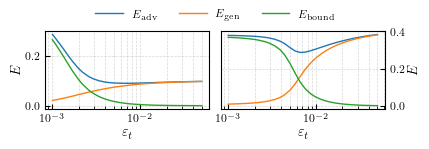

<Figure size 640x480 with 0 Axes>

In [1334]:

IMG_DIRECTORY = "./Assets/optimal_defense"
if not os.path.exists(IMG_DIRECTORY):
    os.makedirs(IMG_DIRECTORY)


def save_plot(fig, name, formats=["pdf","jpg"], date=False):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    for f in formats:        
        path = "{}".format(name) + "_{}".format(current_date) + "." + f
        if not date:
            path = "{}".format(name) + "." + f
        fig.savefig(            
            os.path.join(IMG_DIRECTORY, path),
            format=f,
        )


def set_size(width, fraction=1, subplots=(1, 1)):
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**0.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (golden_ratio) * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

multiplier = 1.25
width = multiplier * 458.63788

plt.style.use("../latex_ready.mplstyle")

tuple_size = set_size(width, fraction=1.0)
tuple_size = (2*8.5/4,2.7/2)

# multiplier = 0.9
# second_multiplier = 0.7

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=False,
    figsize=(tuple_size[0], tuple_size[1]),
    gridspec_kw={"hspace": 0,"wspace":0.07},
)

from matplotlib.pyplot import Line2D

# ICML adjustments
fig.subplots_adjust(left=0.1)
fig.subplots_adjust(bottom=0.22)
fig.subplots_adjust(top=0.8)
fig.subplots_adjust(right=0.9)

axs = axs.flatten()


linestyles = ["solid", "dashed", "dashdot", "dotted"]

for idx, (name, eps_dict) in enumerate(dm_dict.items()):

    axs[idx].grid(which="both", axis="both", alpha=0.5)

    eps_dict = eps_dict[0.006]

    # if idx > 0:
    #     continue

    epsilons = eps_dict["epsilons"]

    adversarial_error = eps_dict["adversarial_error"]
    generalization_error = eps_dict["generalization_error"]
    boundary_error = eps_dict["boundary_error"]
    class_preserving = eps_dict["class_preserving"]

    adversarial_error_erm = eps_dict["adversarial_error_erm"]
    generalization_error_erm = eps_dict["generalization_error_erm"]
    boundary_error_erm = eps_dict["boundary_error_erm"]
    class_preserving_erm = eps_dict["class_preserving_erm"]

    adversarial_error_erm_std = eps_dict["adversarial_error_erm_std"]
    generalization_error_erm_std = eps_dict["generalization_error_erm_std"]
    boundary_error_erm_std = eps_dict["boundary_error_erm_std"]
    class_preserving_erm_std = eps_dict["class_preserving_erm_std"]


    

    axs[idx].plot(epsilons, adversarial_error,  color="C0")
    axs[idx].plot(epsilons, generalization_error, color="C1")
    axs[idx].plot(epsilons, boundary_error,  color="C2")
    # axs[idx].plot(epsilons, class_preserving,  color="C3", linestyle=linestyles[idx])

    # axs[idx].legend(title=name, loc="upper right")
    # axs[idx].legend(title=name, loc="lower center")
    # axs[idx].legend(title=name)

    axs[idx].errorbar(
        epsilons,
        adversarial_error_erm,        
        yerr=adversarial_error_erm_std,
        fmt=".",
        markersize=1,
        color="C0"
    )
    axs[idx].errorbar(
        epsilons,
        generalization_error_erm, 
        yerr=generalization_error_erm_std,
        fmt=".",
        markersize=1,
        color="C1"
    )
    axs[idx].errorbar(
        epsilons,
        boundary_error_erm,        
        yerr=boundary_error_erm_std,
        fmt=".",
        markersize=1,
        color="C2"
    )


    # axs[idx].errorbar(
    #     epsilons,
    #     adversarial_error_erm,
    #     yerr=adversarial_error_erm_std,
        
    #     markersize=1,
    #     linestyle=linestyles[idx],
    #     color="C0"
    # )
    # axs[idx].errorbar(
    #     epsilons,
    #     generalization_error_erm,
    #     yerr=generalization_error_erm_std,
    #     markersize=1,
    #     linestyle=linestyles[idx],
    #     color="C1"
    # )
    # axs[idx].errorbar(
    #     epsilons,
    #     boundary_error_erm,
    #     yerr=boundary_error_erm_std,
        
    #     markersize=1,
    #     linestyle=linestyles[idx],
    #     color="C2"
    # )
    # axs[idx].errorbar(
    #     epsilons,
    #     class_preserving_erm,
    #     yerr=class_preserving_erm_std,
    #     fmt="*",
    #     markersize=1,
    #     color="C3"
    # )

axs[0].set_xscale("log")
# axs[0].set_yscale("log")
axs[0].set_ylabel(r"$E$", labelpad=2.0)
axs[0].set_xlabel(r"$\varepsilon_t$", labelpad=2.0)
# axs[0].grid(which="both", axis="both", alpha=0.5)
axs[0].tick_params(axis='both', which='major', direction='in')
axs[0].tick_params(axis='both', which='minor', direction='in')


axs[1].set_xscale("log")
# axs[1].set_yscale("log")
axs[1].set_ylabel(r"$E$", labelpad=2.0)
axs[1].set_xlabel(r"$\varepsilon_t$", labelpad=2.0)

axs[1].tick_params(axis='both', which='major', direction='in')
axs[1].tick_params(axis='both', which='minor', direction='in')
# axs[1].legend(title="Perturbed", loc="lower left")

# move ylabel and yticklabels to the right
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()



error_legend = []

error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))


fig.legend(handles=error_legend, loc="upper center", ncol=3)

save = True
if save:
    save_plot(
        fig,
        "optimal_defense",
    )

plt.show()

plt.tight_layout()



